In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import Cauchy, Morlet
from scipy import signal


#### Load Example Data from Swarm A Spacecraft Magnetoemter

C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_9928\3332222208.py:44: RuntimeWarning: invalid value encountered in divide
  k_hat_real = np.mean(dw*w2.conj() / (dw*w1.conj()) , axis=1) # WORKS PERFECTLY
C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_9928\3332222208.py:45: RuntimeWarning: invalid value encountered in greater
  invalid = (k_hat_real > 0.5) & (k_hat_real < 2)
C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_9928\3332222208.py:45: RuntimeWarning: invalid value encountered in less
  invalid = (k_hat_real > 0.5) & (k_hat_real < 2)
C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_9928\3332222208.py:51: RuntimeWarning: invalid value encountered in divide
  w_clean = (k*w1-2*w2)/(k-1)


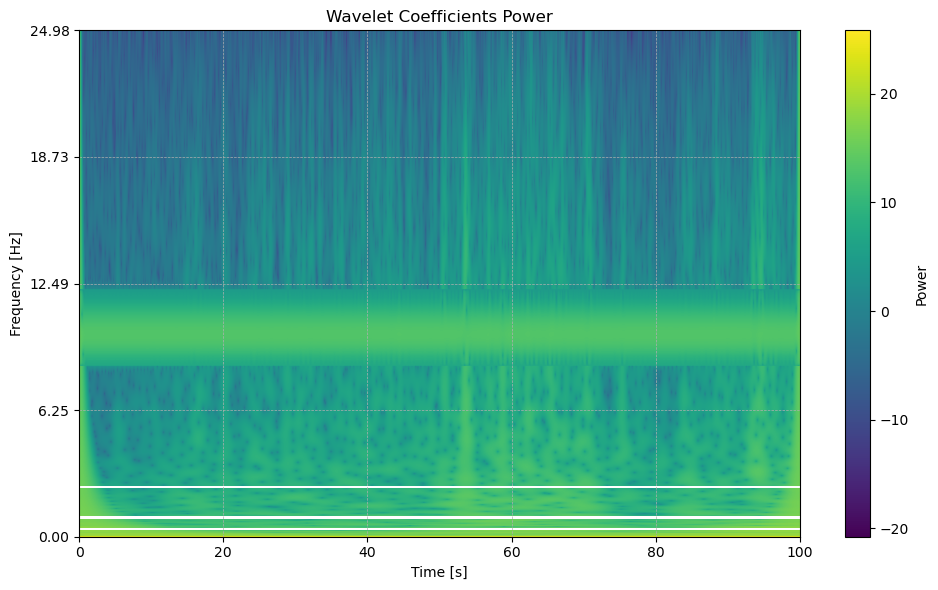

(1250, 5000) (1250, 5000)
nan


c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


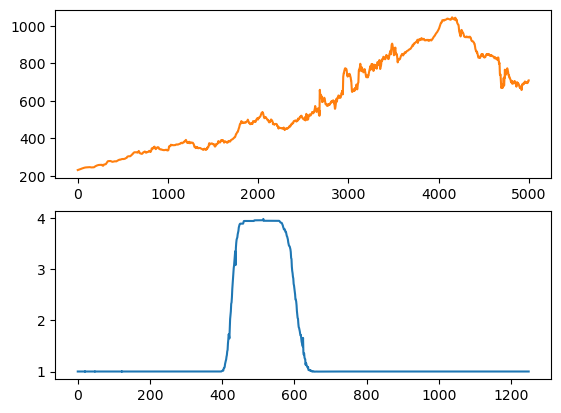

In [14]:
"Load Data"
data = np.load("data.npy")

# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array
B1 = data + 10 *np.sin(2 * np.pi * 10 * t) #+ 50 * np.sin(2 * np.pi * 10 * t)
B2 = data + 40 *np.sin(2 * np.pi * 10 * t) #+ 10*np.sin(2 * np.pi * 10 * t)
B = np.vstack((B1,B2))

"Wavelet Transform"
transform = Transform(
    data=data,
    fs = sample_rate,
    wavelet=Cauchy(),
    pad_method=None, # Padding method for the convolution calls np.pad. Set to None if no padding
    scales='linear'
)

"Perform forward wavelet transform"
w1 = transform.forward(B[0])
w2 = transform.forward(B[1])

"Calculate Gain"
dw = (w2 - w1)
wc1 = np.sum(dw*w1.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)
wc2 = np.sum(dw*w2.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)

"""
k_hat_real = np.where(
    np.abs(wc1) > np.percentile(np.abs(wc1), 95),
    np.mean(dw*w2.conj() / (dw*w1.conj()) , axis=1),
    np.nan
)
valid = ~np.isnan(k_hat_real)
first, last = np.flatnonzero(valid)[0], np.flatnonzero(valid)[-1]
k_hat_real[:first] = k_hat_real[first]
k_hat_real[last + 1:] = k_hat_real[last]
k_hat_real[~valid] = np.interp(np.flatnonzero(~valid),
                              np.flatnonzero(~valid),
                              k_hat_real[~valid])
"""
k_hat_real = np.mean(dw*w2.conj() / (dw*w1.conj()) , axis=1) # WORKS PERFECTLY
invalid = (k_hat_real > 0.5) & (k_hat_real < 2)

# K must be max 0.6 or min 1.6
"Calculate clean signal"
k = k_hat_real[:,np.newaxis]

w_clean = (k*w1-2*w2)/(k-1)
w_clean[invalid] = w1[invalid]

transform.power_scalogram(w_clean)
result = transform.inverse(np.copy(w_clean))
print(np.sqrt(((data-result)**2).mean(axis=0)))
fig, ax = plt.subplots(2,1)
ax[0].plot(result)
ax[0].plot(data)    
ax[1].plot(k_hat_real)


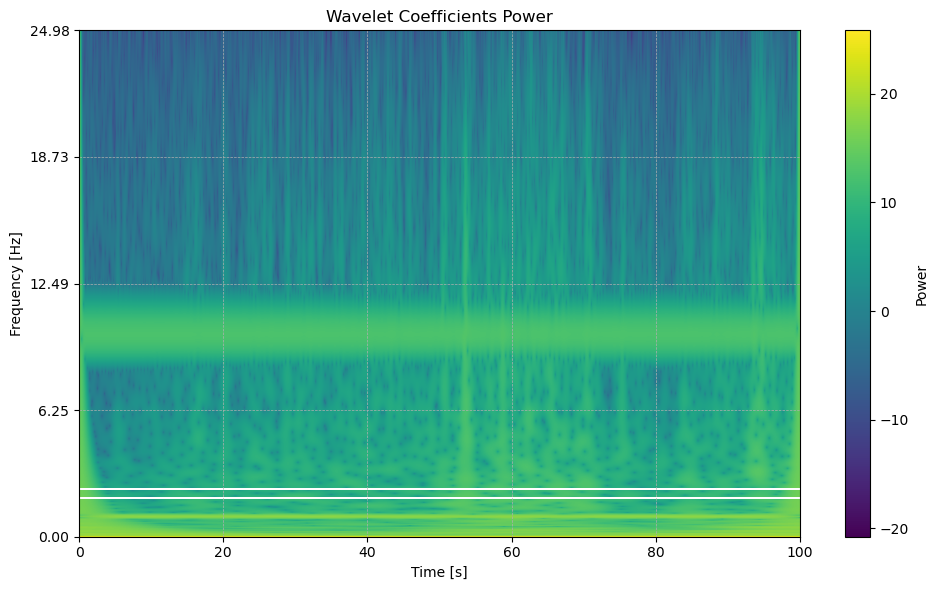

In [3]:
transform.power_scalogram(w_clean)


-0.3434343434343434


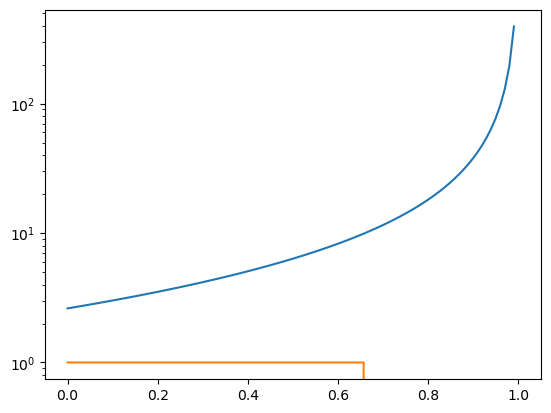

In [4]:
cond = []
for i in np.linspace(0,1,100):
    cond.append(np.linalg.cond(np.array([[1,1],[i,1]])))

plt.plot(np.linspace(0,1,100), cond)
plt.plot(np.linspace(0,1,100),np.array(cond)<10)
plt.yscale('log')
cond = np.array(cond)
print(np.linspace(0,1,100)[cond<10][-1]-1)

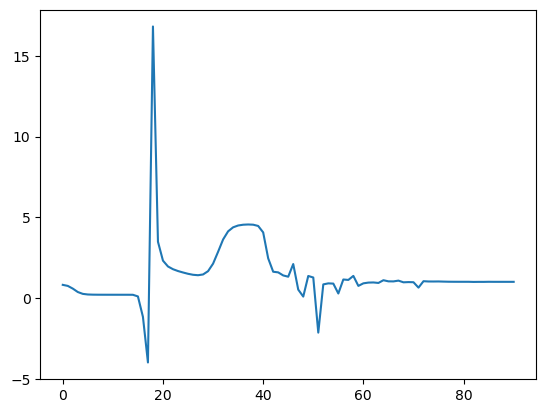

In [5]:

from wavelets import WaveletAnalysis
w1 = WaveletAnalysis(B[0], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)
w2 = WaveletAnalysis(B[1], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)

"Transform signals into wavelet domain"
wn1 = w1.wavelet_transform.real
wn2 = w2.wavelet_transform.real

"Sheinker and Moldwin's Algorithm"
dw = wn2-wn1
wc1 = np.sum(dw*wn1, axis=1)
wc2 = np.sum(dw*wn2, axis=1)
k_hat_real = wc2/wc1
plt.plot(k_hat_real)

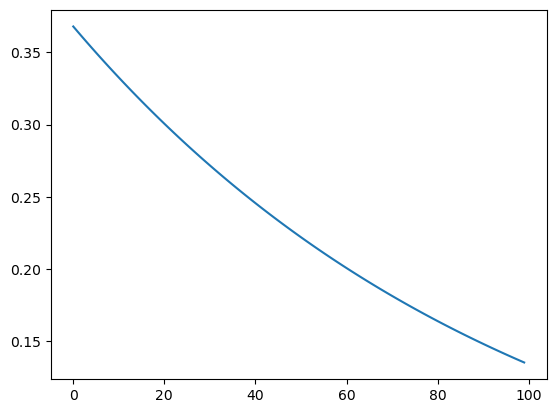

In [6]:
plt.plot(np.exp(-1*np.linspace(0,1,100)-1))
